In [1]:
from datamarket import *

In [2]:
# star schema
# number of dimensions
dimensions = 4
# size of each dimension
# assume each dimension has one attribute
dimensions_size = 20
# sparsity of fact table
# sparse = 0.3

In [3]:
# 1st dimension is A, 2nd dimension is B, ...
def get_dimension_name(d):
    return chr(ord('A') + d)

def generate_dimension_table(d):
    name = get_dimension_name(d)
    df = pd.DataFrame()
    df[name] = range(dimensions_size)
    df[name + "_att"] = choices(range(50), k=dimensions_size)
    return df

In [6]:
dimention_tables = []
for i in range(dimensions):
    dimention_tables.append(generate_dimension_table(i))

fact_table = pd.DataFrame()
for d in range(dimensions):
    name = get_dimension_name(d)
    fact_table[name] = [item for item in range(dimensions_size) for i in range(int(pow(dimensions_size,d)))] * int(pow(dimensions_size,dimensions - 1 - d))
# fact_table = fact_table.sample(frac=sparse, replace=True, random_state=1)

# join fact table with dimension tables
join_result = None
for i in range(dimensions):
    if i == 0:
        join_result = pd.merge(fact_table, dimention_tables[0])
    else:
        join_result = pd.merge(join_result, dimention_tables[i])

In [7]:
join_result

,A,B,C,D,A_att,B_att,C_att,D_att
0,0,0,0,0,33,6,33,11
1,1,0,0,0,27,6,33,11
2,2,0,0,0,16,6,33,11
3,3,0,0,0,28,6,33,11
4,4,0,0,0,8,6,33,11
...,...,...,...,...,...,...,...,...
159995,15,19,19,19,14,21,46,28
159996,16,19,19,19,26,21,46,28
159997,17,19,19,19,35,21,46,28
159998,18,19,19,19,8,21,46,28


In [8]:
join_result["result"] = 0
for i in range(dimensions):
    name = get_dimension_name(i)
    join_result["result"] += join_result[name + "_att"] * join_result[name + "_att"]
join_result

,A,B,C,D,A_att,B_att,C_att,D_att,result
0,0,0,0,0,33,6,33,11,2335
1,1,0,0,0,27,6,33,11,1975
2,2,0,0,0,16,6,33,11,1502
3,3,0,0,0,28,6,33,11,2030
4,4,0,0,0,8,6,33,11,1310
...,...,...,...,...,...,...,...,...,...
159995,15,19,19,19,14,21,46,28,3537
159996,16,19,19,19,26,21,46,28,4017
159997,17,19,19,19,35,21,46,28,4566
159998,18,19,19,19,8,21,46,28,3405


In [5]:
# randomly generated coefficients as ground truth
coefficients = choices(range(50), k=dimensions)
constant = choices(range(50), k=1)
print(coefficients, constant)

join_result["result"] = constant[0]
for i in range(dimensions):
    name = get_dimension_name(i)
    join_result["result"] += coefficients[i] * join_result[name + "_att"]
join_result

[31, 23, 43, 27] [38]


,A,B,C,D,A_att,B_att,C_att,D_att,result
0,0,0,0,0,9,45,22,47,3567
1,1,0,0,0,28,45,22,47,4156
2,2,0,0,0,36,45,22,47,4404
3,3,0,0,0,43,45,22,47,4621
4,4,0,0,0,25,45,22,47,4063
...,...,...,...,...,...,...,...,...,...
159995,15,19,19,19,13,32,24,46,3451
159996,16,19,19,19,10,32,24,46,3358
159997,17,19,19,19,15,32,24,46,3513
159998,18,19,19,19,14,32,24,46,3482


In [62]:
join_result = join_result.loc[:, join_result.columns != 'A_att']
join_result

,A,B,C,D,B_att,C_att,D_att,result
0,0,0,0,0,3,14,16,1840
1,1,0,0,0,3,14,16,2764
2,2,0,0,0,3,14,16,2512
3,3,0,0,0,3,14,16,1504
4,4,0,0,0,3,14,16,2680
...,...,...,...,...,...,...,...,...
159995,15,19,19,19,22,43,8,4941
159996,16,19,19,19,22,43,8,4227
159997,17,19,19,19,22,43,8,4983
159998,18,19,19,19,22,43,8,5025


In [92]:
# repeat dimensional table multiple times
dup = 4
aug = dimention_tables[0].append([dimention_tables[0]]*dup,ignore_index=True)

In [71]:
test = agg_dataset()
test.load_buyer(join_result, [get_dimension_name(i) + "_att" for i in range(1,dimensions-1)], "result", [get_dimension_name(i) for i in range(dimensions-1)], "test")
test.compute_agg()

/home/jupyter/arda/arda-datasets/school/datamarket.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[att] = pd.to_numeric(self.data[att],errors="coerce")


In [93]:
dima = agg_dataset()
dima.load_seller(aug, ["A"], "A",False)
dima.compute_agg(True)

/home/jupyter/arda/arda-datasets/school/datamarket.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['cov:c'] = 1
/home/jupyter/arda/arda-datasets/school/datamarket.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['cov:Q:' + tablename + ":" + attributes[i] + ","+ tablename + ":" + attributes[j]] = self.data[attributes[i]] * self.data[attributes[j]]


In [66]:
def connect(aggdata1, aggdata2, dimension, left_inp = False, right_attrs = []):
    
    if isinstance(dimension, list):
        dimension = tuple(dimension)
    
    if left_inp:
        agg1 = aggdata1.data
    else:
        agg1 = aggdata1.agg_dimensions[dimension]
        
    agg2 = aggdata2.agg_dimensions[dimension]
    
    left_attributes = aggdata1.X
    left_tablename = aggdata1.name
    right_attributes = aggdata2.X
    right_tablename = aggdata2.name
    
    if len(right_attrs) > 0:
        kept_cols = []
        for col in agg2.columns:
            names = col[6:].split(",")
            match = True
            for name in names:
                if name not in right_attrs:
                    match = False
            if match:
                kept_cols.append(col)
        agg2 = agg2[kept_cols + ['cov:c']]
        right_attributes = right_attrs
    
    
    if left_inp:
        join = pd.merge(agg1, agg2.loc[:, agg2.columns != 'cov:c'], how='left', left_on=dimension, right_index=True)
    else:
        join = pd.merge(agg1, agg2.loc[:, agg2.columns != 'cov:c'], how='left', left_index=True, right_index=True)
#         join = pd.merge(agg1, agg2, how='inner', left_index=True, right_index=True)
#     join = join.drop('cov:c_y', 1)
#     join = join.rename(columns = {'cov:c_x':'cov:c'})
    
    right_cov = aggdata2.covariance

    
    # fill in nan
    for att2 in right_attributes:
        join['cov:s:' + att2].fillna(value=right_cov['cov:s:' + att2], inplace=True)
        join['cov:s:' + att2] *= join['cov:c']
    
    for i in range(len(right_attributes)):
        for j in range(i, len(right_attributes)):
            if 'cov:Q:' + right_attributes[i] + "," + right_attributes[j] in join:
                join['cov:Q:' + right_attributes[i] + "," + right_attributes[j]].fillna(value=right_cov['cov:Q:' + right_attributes[i] + "," + right_attributes[j]], inplace=True)
                join['cov:Q:' + right_attributes[i] + "," + right_attributes[j]] *= join['cov:c']
            else:
                join['cov:Q:' + right_attributes[j] + "," + right_attributes[i]].fillna(value=right_cov['cov:Q:' + right_attributes[j] + "," + right_attributes[i]], inplace=True)
                join['cov:Q:' + right_attributes[j] + "," + right_attributes[i]] *= join['cov:c']
            
    
    
    for att1 in left_attributes:
        for att2 in right_attributes:
            if 'cov:Q:' + att1 + "," + att2 in join:
                join['cov:Q:' + att1 + "," + att2] = join['cov:s:' + att1] * join['cov:s:' + att2]/join['cov:c']
            else:
                join['cov:Q:' + att2 + "," + att1] = join['cov:s:' + att2] * join['cov:s:' + att1]/join['cov:c']
    
    
    return join

In [95]:
%%time
join_test = connect(test, dima, "A")
join_test_cov = join_test.sum()
parameter = linear_regression(join_test_cov,["A:A_att"] + ["test:" + get_dimension_name(i) + "_att" for i in range(1, dimensions-1)], "test:result")
r2(join_test_cov, ["A:A_att"] + ["test:" + get_dimension_name(i) + "_att" for i in range(1, dimensions-1)],"test:result", parameter)

CPU times: user 10.5 ms, sys: 2.85 ms, total: 13.3 ms
Wall time: 11 ms


0.9957306245485813

In [98]:
%%time
join_naive = pd.merge(join_result, aug, how='inner', left_on = 'A', right_on = 'A')
reg = LinearRegression().fit(join_naive[[get_dimension_name(i) + "_att" for i in range(dimensions-1)]], join_naive[["result"]])
r2_score(join_naive[["result"]],reg.predict(join_naive[[get_dimension_name(i) + "_att" for i in range(dimensions-1)]]))

CPU times: user 212 ms, sys: 128 ms, total: 340 ms
Wall time: 266 ms


0.9957306245485857

In [38]:
# repeat dimensional table multiple times
dup = 4
aug_join = join_result.append([join_result]*dup,ignore_index=True)

In [43]:
%%time
reg = LinearRegression().fit(aug_join[[get_dimension_name(i) + "_att" for i in range(dimensions-1)]], aug_join[["result"]])
r2_score(aug_join[["result"]],reg.predict(aug_join[[get_dimension_name(i) + "_att" for i in range(dimensions-1)]]))

CPU times: user 161 ms, sys: 116 ms, total: 277 ms
Wall time: 184 ms


0.8200446120838962

In [23]:
len(aug_join)

320000

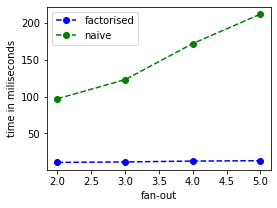

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x = [2,3,4,5]
# x = [160000,320000,480000,640000]
y1 = [10.6,11.2,12.4,12.9]
# y2 = [12.6, 19.8, 52.2, 1260]
y2 = [97.1,123,172,212]
# y2 = [53.3,95.3,130 ,166]
plt.figure(figsize=(4, 3))
plt.plot(x, y1,'--bo', label='factorised') 
plt.plot(x, y2,'--go', label='naive') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("fan-out")
# plt.xlabel("# rows to augment")
plt.ylabel("time in miliseconds")
# plt.title("With Labels")

# plt.show()
# plt.savefig("vertical_many_to_one.pdf", bbox_inches='tight')
plt.savefig("vertical_many_to_many.pdf", bbox_inches='tight')
# plt.savefig("horizontal_fac.pdf", bbox_inches='tight')


In [ ]:
Test performae for size of dimension.
Test performance for many-to-many join.
Test PCA.
Maybe backward selection?
Decimal?

assume each dimension has 20 attributes.
2
10.6 ms vs 12.6 ms
3
11.2 ms vs 19.8 ms
4
12.4 ms vs 52.2 ms
5
12.9 ms vs 1260 s

duplicate
1: 11.7 ms vs 97.1 ms
2: 12.2 ms vs 123 ms
3: 8.33 ms vs 172 ms
4: 10.5 ms vs 212 ms



In [ ]:
For PCA standardize them to mean/std (0,1)

One problem with PCA: missing join keys.

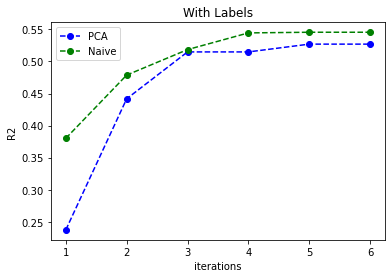

In [30]:
import matplotlib.pyplot as plt
import numpy as np

x = [1,2,3,4,5,6]
y1 = [0.23732626400078338,0.44174035936524314,0.5148473111081161,0.5148473111081161, 0.5269850638379274, 0.5269850638379274]
y2 = [0.38011516079311647,0.4787090065018217,0.518473380251455,0.5444965625559399,0.5455193557294014,0.5455193557294895]
plt.figure()
plt.plot(x, y1,'--bo', label='PCA') 
plt.plot(x, y2,'--go', label='Naive') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("iterations")
plt.ylabel("R2")
plt.title("With Labels")

plt.show()


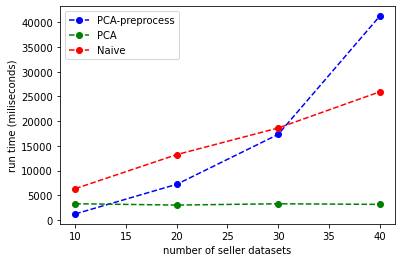

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 5 iteration 10 best features
# each with 5 features?
# when 50 seller datasets, there are 200 features and we need to compute 200^2=40000 pairs
x = [10, 20, 30, 40]
y1 = [1231,7223,17323,41232]
y2 = [3294,3021,3283,3160]
y3 = [6343,13233,18623, 25931]
plt.figure()
plt.plot(x, y1,'--bo', label='PCA-preprocess') 
plt.plot(x, y2,'--go', label='PCA') 
plt.plot(x, y3,'--ro', label='Naive') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("number of seller datasets")
plt.ylabel("run time (miliseconds)")

plt.show()

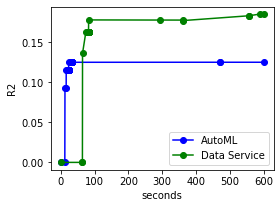

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# df1 = pd.read_csv("automl_result3.csv")
# df2 = pd.read_csv("automl_result2.csv")
# df1 = pd.read_csv("automl_service_eth.csv")
# df2 = pd.read_csv("automl_naive_eth.csv")
# df1 = pd.read_csv("automl_service_survey.csv")
# df2 = pd.read_csv("automl_naive_survey.csv")
df1 = pd.read_csv("automl_service_vax.csv")
df2 = pd.read_csv("automl_naive_vax.csv")

plt.figure(figsize=(4, 3))
plt.plot(df2["duration"], df2["ensemble_test_score"],'-bo', label='AutoML') 
plt.plot(df1["duration"], df1["ensemble_test_score"],'-go', label='Data Service') 
# plt.plot([0,600], [0,0],'-ro', label='Naive Data Service') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("seconds")
plt.ylabel("R2")

# plt.show()

plt.savefig("marketvalue_vax.pdf", bbox_inches='tight')

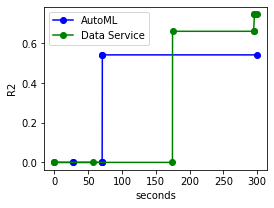

In [11]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df1 = pd.read_csv("automl_result_market_300_100.csv")
df2 = pd.read_csv("automl_naive_300_100.csv")



plt.figure(figsize=(4, 3))
plt.plot(df2["duration"], df2["ensemble_test_score"],'-bo', label='AutoML') 
plt.plot(df1["duration"], df1["ensemble_test_score"],'-go', label='Data Service') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("seconds")
plt.ylabel("R2")

# plt.show()

plt.savefig("marketvalue5.pdf", bbox_inches='tight')

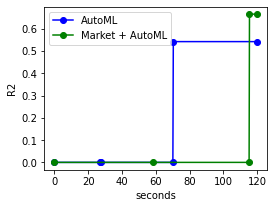

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df1 = pd.read_csv("automl_result_market_120_40.csv")
df2 = pd.read_csv("automl_naive_120_40.csv")



plt.figure(figsize=(4, 3))
plt.plot(df2["duration"], df2["ensemble_test_score"],'-bo', label='AutoML') 
plt.plot(df1["duration"], df1["ensemble_test_score"],'-go', label='Market + AutoML') 
plt.legend()
# plt.xlabel("number of dimensions")
plt.xlabel("seconds")
plt.ylabel("R2")
# plt.title("With Labels")

# plt.show()

plt.savefig("marketvalue2.pdf", bbox_inches='tight')

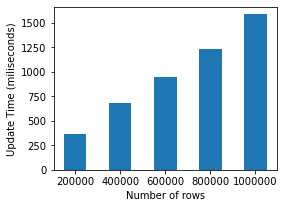

In [43]:
import numpy as np
import matplotlib.pyplot as plt
 
courses = ['200000','400000','600000','800000','1000000']
values = [361, 684, 951, 1231, 1585]
  
fig = plt.figure(figsize=(4, 3))
 
# creating the bar plot
plt.bar(courses, values, width = 0.5)
 
plt.xlabel("Number of rows")
plt.ylabel("Update Time (miliseconds)")
# plt.show()

plt.savefig("Preprocess.pdf", bbox_inches='tight')

In [15]:
join_train = join_result[join_result["A_att"] < 10]

In [16]:
# buyer
reg = LinearRegression().fit(join_train[["A_att","B_att"]], join_train[["result"]])

r2_score(join_result[["result"]],reg.predict(join_result[["A_att","B_att"]]))

0.09188835357729364

In [17]:
# only column
reg = LinearRegression().fit(join_train[["A_att","B_att", "C_att","D_att"]], join_train[["result"]])
r2_score(join_result[["result"]],reg.predict(join_result[["A_att","B_att", "C_att","D_att"]]))

0.6196142611876678

In [24]:
join_train = join_result[join_result["A_att"] < 20]

In [25]:
# only row
reg = LinearRegression().fit(join_train[["A_att","B_att"]], join_train[["result"]])
r2_score(join_result[["result"]],reg.predict(join_result[["A_att","B_att"]]))

0.2422488456513846

In [26]:
# both
reg = LinearRegression().fit(join_train[["A_att","B_att", "C_att","D_att"]], join_train[["result"]])
r2_score(join_result[["result"]],reg.predict(join_result[["A_att","B_att", "C_att","D_att"]]))

0.7699747532617591

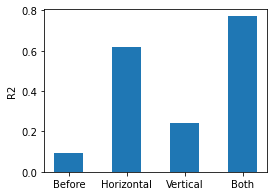

In [29]:
courses = ['Before','Horizontal','Vertical','Both']
values = [0.09188835357729364, 0.6196142611876678, 0.2422488456513846, 0.7699747532617591]
  
fig = plt.figure(figsize=(4, 3))
 
# creating the bar plot
plt.bar(courses, values, width = 0.5)
 
# plt.xlabel("Number of rows")
plt.ylabel("R2")
# plt.show()

plt.savefig("h_v_aug.pdf", bbox_inches='tight')

In [38]:
row = 1000000
ran_df =pd.DataFrame()
ran_df["DBN"] = range(row)
ran_df["att1"] = np.random.randint(1, 100, row)
ran_df["att2"] = np.random.randint(1, 100, row)
ran_df["att3"] = np.random.randint(1, 100, row)
ran_df["att4"] = np.random.randint(1, 100, row)
ran_df["att5"] = np.random.randint(1, 100, row)

In [39]:
%%time
randomdata = agg_dataset()
randomdata.load(ran_df, [], ["DBN"], "random" )
randomdata.find_features()
randomdata.remove_redundant_columns()
randomdata.standardize_all()
randomdata.compute_agg(True)

CPU times: user 1.52 s, sys: 211 ms, total: 1.73 s
Wall time: 1.73 s
